<a href="https://colab.research.google.com/github/andreagurioli1995/IoT-Air-Quality-Monitoring-System/blob/stable/forecasting/forecasting-fbprophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas
!pip install influxdb_client
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 698 kB 5.5 MB/s 
     |████████████████████████████████| 138 kB 46.2 MB/s 
     |████████████████████████████████| 199 kB 44.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/pu

In [2]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Data retrival from influx

In [ ]:
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS
token = 'XcmfhaTm0yJzZhnThQBO26FZvYgtP0QJAocHVUucCoXcr9Vmymk69vOrJJ42_G03Y3h35KG0iapZM4dSE49AwQ=='
#bucket = $my-bucket
org = 'iot-org'
client = InfluxDBClient(url="http://localhost:8086", token=token, org=org)
query_api = client.query_api()
write_api = client.write_api(write_options=SYNCHRONOUS)

In [ ]:
query = 'from(bucket:"temperature")' \
        ' |> range(start:2007-12-10T15:00:00Z, stop:2016-01-20T15:00:00Z)'\
        ' |> filter(fn: (r) => r._measurement == "views")' \
        ' |> filter(fn: (r) => r._field == "y")'

In [ ]:
result = client.query_api().query(org=org, query=query)

-Exploiting the query results in order to obtain a dataframe

In [ ]:
raw = []
for table in result:
    for record in table.records:
        raw.append((record.get_value(), record.get_time()))
print("=== influxdb query into dataframe ===")
print()
df=pd.DataFrame(raw, columns=['y','ds'], index=None)
df['ds'] = df['ds'].values.astype('<M8[D]')
df.head()

In [29]:
dataset_path = "/content/temp.csv"
df = pd.read_csv(dataset_path)
df["Time"]= pd.DatetimeIndex(df["Time"])
#date_time = pd.to_datetime(df.pop('Time'), format='%Y-%m-%d %H:%M:%S')
df.rename(columns={'Time':'ds','value {host="c8c9a3c96888", lat="44.59700012", lng="11.25300026"}':'y'},inplace=True)

In [30]:
df.head()

,ds,y
0,2022-06-04 12:36:08,28.5
1,2022-06-04 12:36:11,28.5
2,2022-06-04 12:36:13,28.5
3,2022-06-04 12:36:16,28.5
4,2022-06-04 12:36:19,28.5


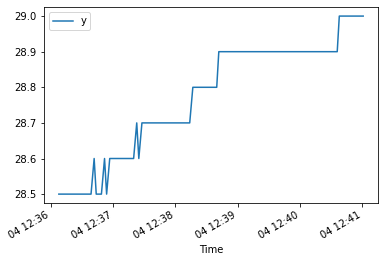

In [31]:
#evolution over time of our data
plot_cols = ['y']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)



In [32]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
y,115.0,28.772174,0.162517,28.5,28.6,28.8,28.9,29.0


In [33]:
nrows = (len(df.values))
splitPoint = int (nrows * 0.80)
train = df['y'] [:splitPoint]
test = df ['y'] [splitPoint: ]

Check for stationarity 

In [34]:
 #Step 3: Check whether the time-series is stationary through the Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(train)

print('ADF Statistic: %f' % result[0])

print('p-value: %f' % result[1])

ADF Statistic: -1.042090
p-value: 0.737605


In [35]:
train_new = train.diff().dropna()

result = adfuller(train_new)

print('ADF Statistic: %f' % result[0])

print('p-value: %f' % result[1])

ADF Statistic: -16.858545
p-value: 0.000000


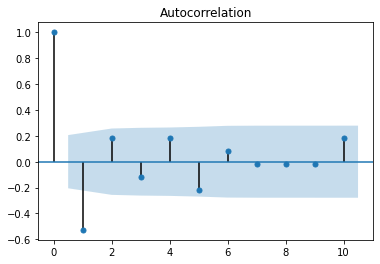

In [36]:
from statsmodels.graphics import tsaplots
fig = tsaplots.plot_acf(train_new, lags=10)
plt.show()

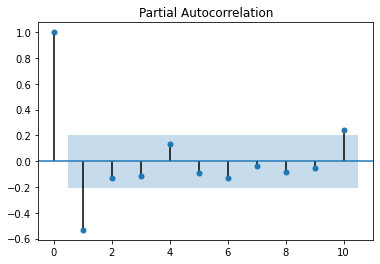

In [37]:
fig = tsaplots.plot_pacf(train_new, lags=10)
plt.show()

In [45]:
#Step 6; Apply ARIMA model
from statsmodels.tsa.arima_model import ARIMA
history = [x for x in train]
predictions = list()
print(test)
for t in test.index:
  model = ARIMA(history, order=(1,2,2))
  model_fit = model. fit()
  output = model_fit.forecast()
  yest = output[0]
  predictions.append(yest)
  obs= test[t]
  history.append(obs)
  print ('predicted=%f, expected=%f' % (yest, obs))

92     28.9
93     28.9
94     28.9
95     28.9
96     28.9
97     28.9
98     28.9
99     28.9
100    28.9
101    28.9
102    28.9
103    28.9
104    28.9
105    29.0
106    29.0
107    29.0
108    29.0
109    29.0
110    29.0
111    29.0
112    29.0
113    29.0
114    29.0
Name: y, dtype: float64
predicted=28.904441, expected=28.900000
predicted=28.904161, expected=28.900000
predicted=28.903894, expected=28.900000
predicted=28.903636, expected=28.900000
predicted=28.903390, expected=28.900000
predicted=28.903153, expected=28.900000
predicted=28.902926, expected=28.900000


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:221: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


predicted=28.902704, expected=28.900000
predicted=28.902496, expected=28.900000
predicted=28.902295, expected=28.900000
predicted=28.902101, expected=28.900000
predicted=28.901913, expected=28.900000
predicted=28.901735, expected=28.900000
predicted=28.901560, expected=29.000000
predicted=28.944501, expected=29.000000
predicted=28.994773, expected=29.000000
predicted=29.004750, expected=29.000000
predicted=29.006391, expected=29.000000
predicted=29.006554, expected=29.000000
predicted=29.006381, expected=29.000000
predicted=29.006139, expected=29.000000
predicted=29.005889, expected=29.000000
predicted=29.005645, expected=29.000000


Test RMSE: 0.024


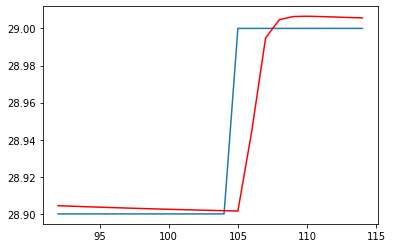

In [48]:
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f'% rmse)

df2 = pd. DataFrame (predictions)
df2. set_index(test.index, inplace=True)
plt.plot(test)
plt.plot(df2, color='red')
plt.show( )